# DIVAnd in generalized vertical coordinates
## Import packages

In [1]:
using NCDatasets
using DataStructures
using DIVAnd
using Dates
using Statistics
using Random
using Makie, CairoMakie, GeoMakie
using Interpolations
using Roots
include("../config.jl")

"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

## Configuration
* Define the horizontal, vertical (depth levels) and temporal resolutions.
* Select the variable of interest

In [2]:
dx, dy = 0.125, 0.125
lonr = 11.5:dx:20
latr = 39:dy:46

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
#depthr = depthr[1:30];

## Read your ODV file
Adapt the `datadir` and `datafile` values.     
The example is based on a sub-setting of the [Mediterranean Sea](https://www.seadatanet.org/Products#/metadata/cd552057-b604-4004-b838-a4f73cc98fcf) aggregated dataset.      
The dataset has been extracted around the Adriatic Sea and exported to a netCDF using [Ocean Data View](https://odv.awi.de/).
<img src="./Images/MedSeaAggreg.jpg" width="450px">

Download the data files (test and full) if needed.

In [3]:
datafile = adriaticfile
download_check(datafile, adriaticfileURL)

[ Info: File already downloaded


Read the full file:

In [4]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, datafile, 
    "Water body salinity");
aspectratio = 1/cos(mean(latr) * pi/180)

  6.606301 seconds (13.58 M allocations: 933.338 MiB, 4.26% gc time, 75.53% compilation time)


1.3563417049092568

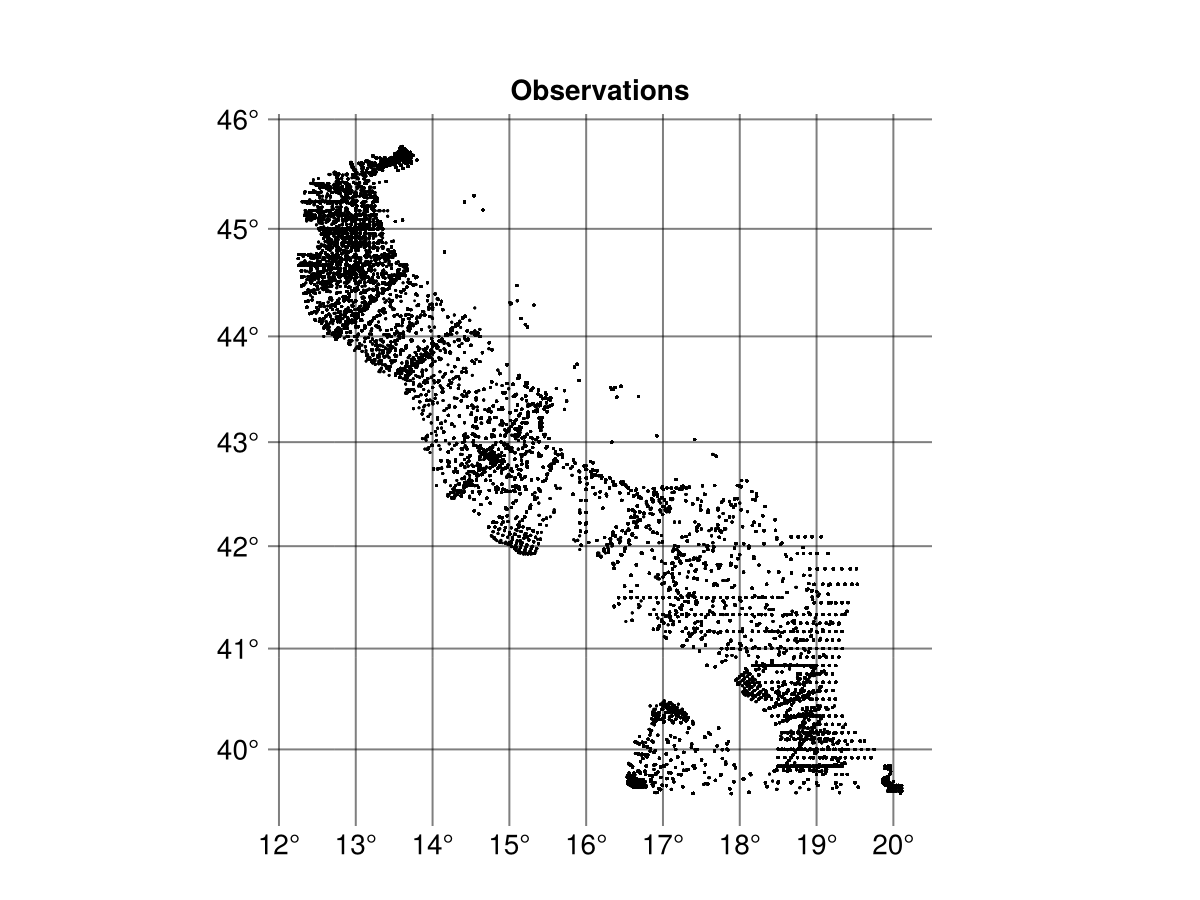

In [7]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Observations")
scatter!(ax, obslon, obslat; markersize=2, color = :black)
f

Check the extremal values of the observations

In [8]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (12.25016975402832, 20.110000610351562)
              minimum and maximum of obs. dimension 2: (39.556758880615234, 45.755001068115234)
              minimum and maximum of obs. dimension 3: (0.0, 1484.2030029296875)
              minimum and maximum of obs. dimension 4: (DateTime("1911-08-17T09:24:00"), DateTime("2015-02-10T10:43:00"))
                          minimum and maximum of data: (4.070000171661377, 40.880001068115234)


## Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### Choice of bathymetry
Modify `bathname` according to the resolution required.

In [9]:
bathname = gebco08file
download_check(bathname, gebco08fileURL)

[ Info: File already downloaded


In [10]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  2.010010 seconds (5.56 M allocations: 283.288 MiB, 1.68% gc time, 97.07% compilation time)


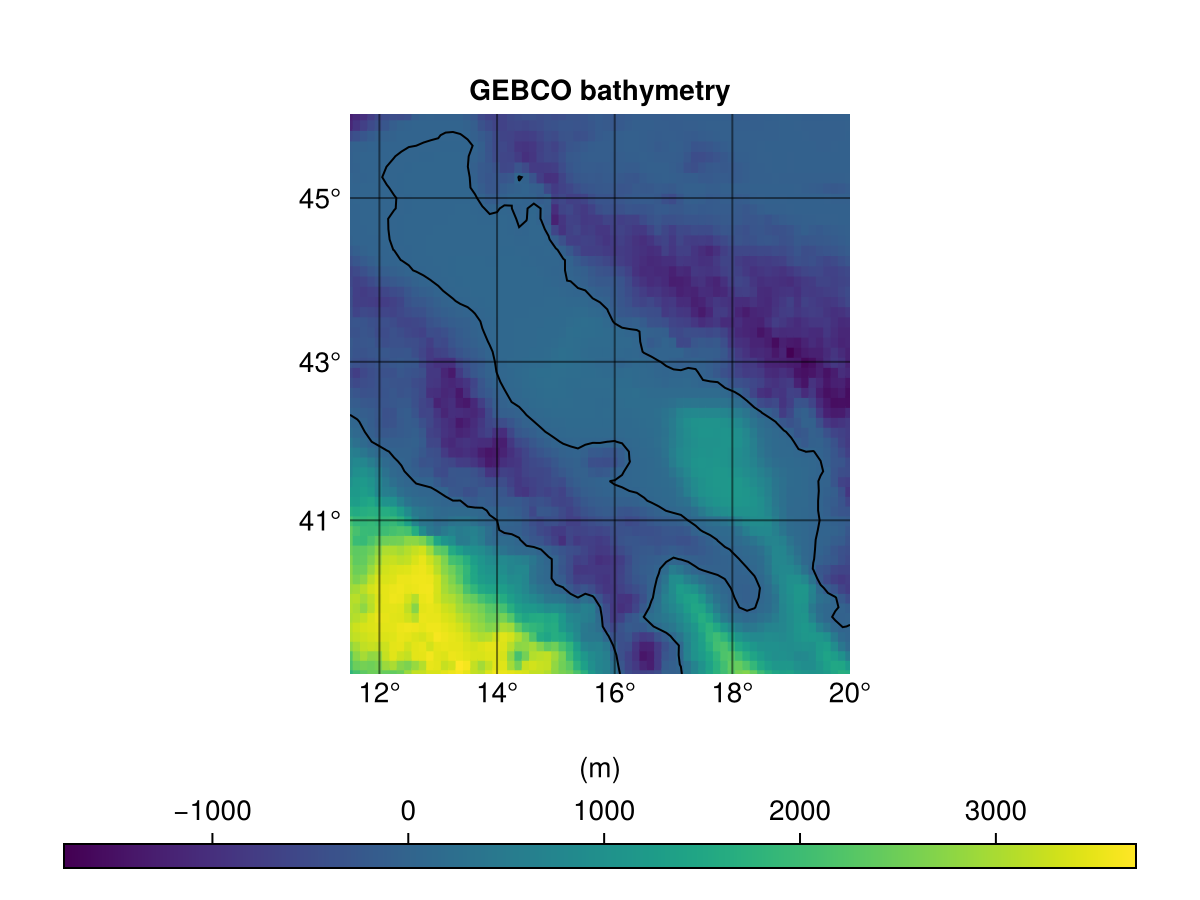

In [11]:
plot_bathy(bx, by, b, xticks=10.:2.:20., yticks=39.:2:48.)

### Create mask
* False for sea        
* True for land

In [59]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (69, 57, 51)


(69, 57, 51)

We plot the surface mask, other levels can be shown by changing the last index in `Mask[]`.

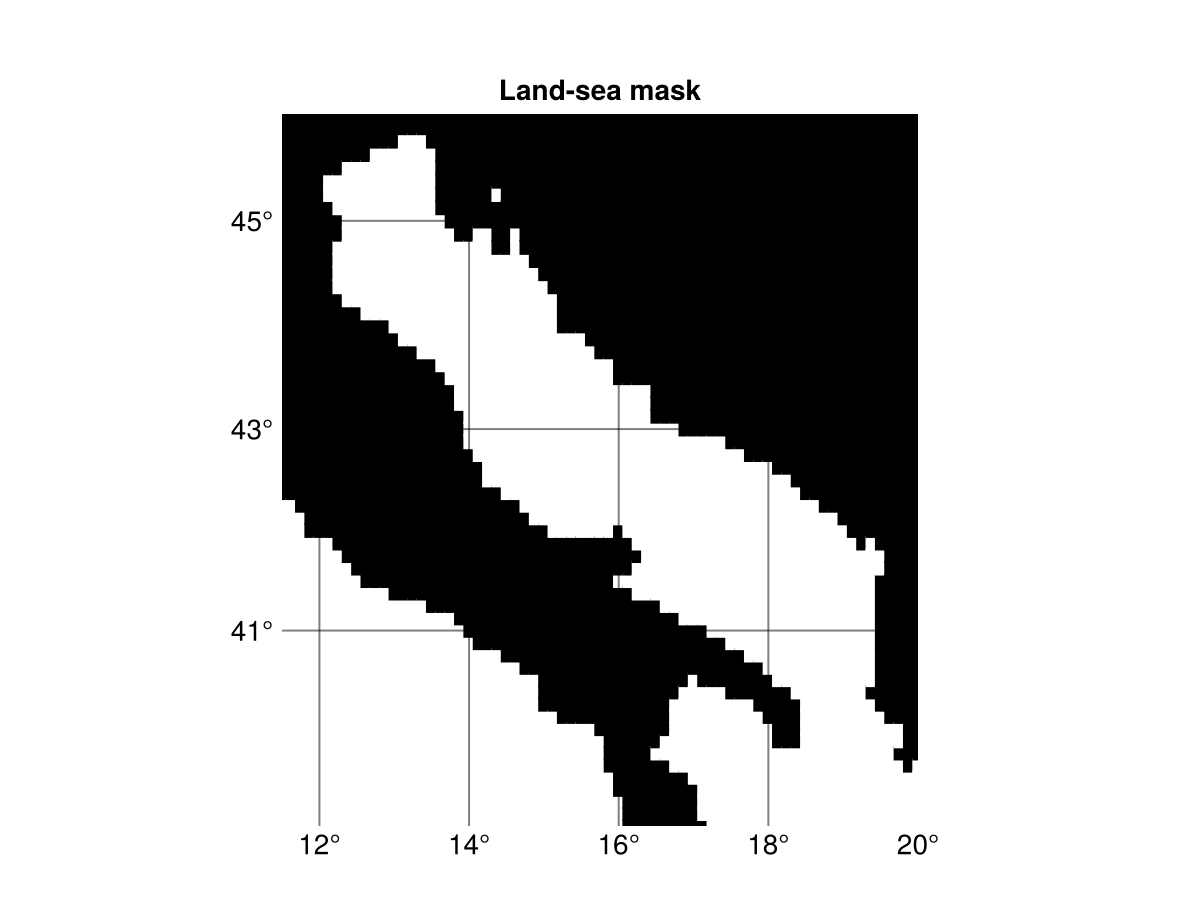

In [60]:
plot_mask(bx, by, mask[:,:,1], xticks=10.:2.:20., yticks=39.:2:48.)

### Edit the mask
As an example we will remove the Tyrrhenian Sea from the domain.

In [61]:
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

In [62]:
mask_edit = copy(mask);
sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;
@show size(mask_edit)

size(mask_edit) = (69, 57, 51)


(69, 57, 51)

The edited mask (also at the surface) now looks like this:

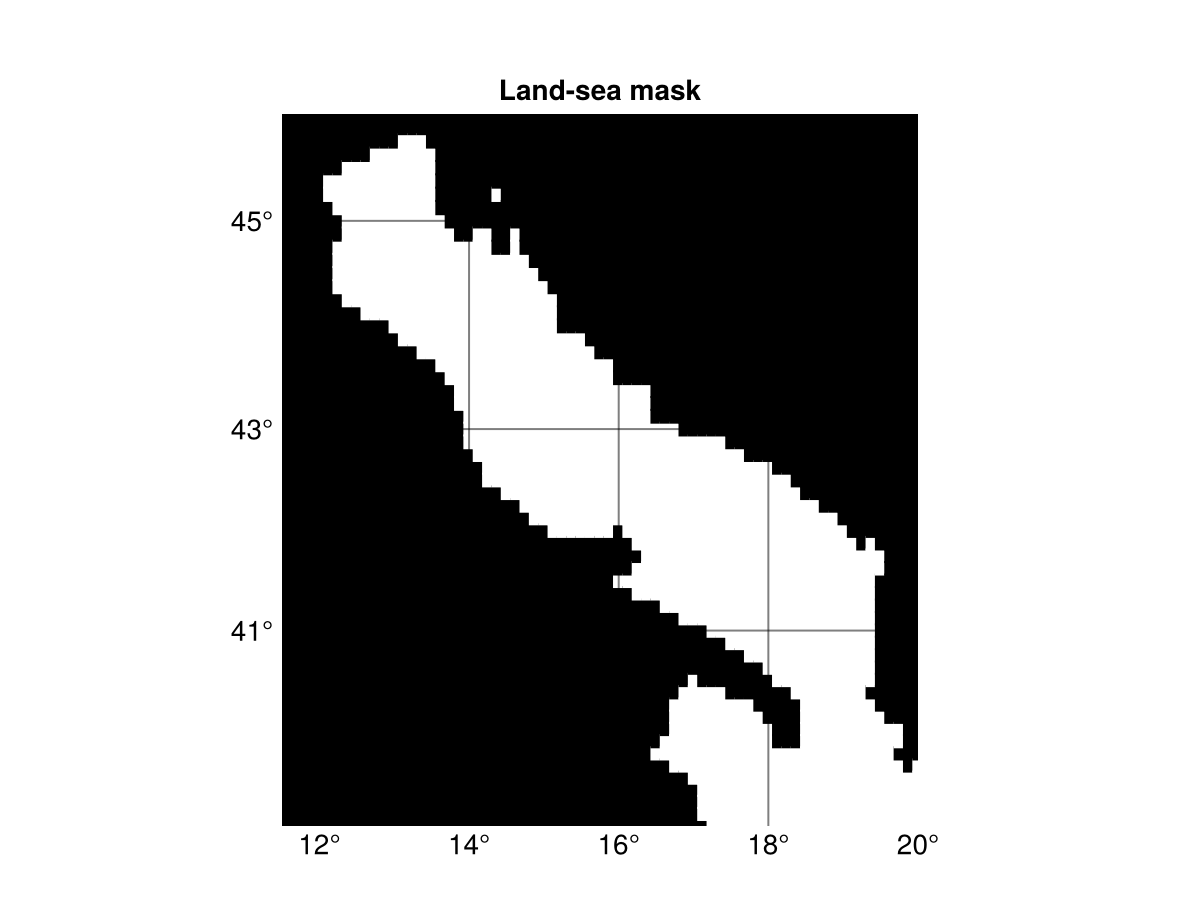

In [63]:
plot_mask(bx, by, mask_edit[:,:,1], xticks=10.:2.:20., yticks=39.:2:48.)

## Define a vertical correlation length function in real space

In [64]:
function Lvert(x,y,z)
    return 5.0 + z/5.0
end

LHOR=.5
eps2=0.01
iscyclic=falses(3)

3-element BitVector:
 0
 0
 0

## For comparison, analysis in Cartesian Coordinates (degrees for simplicity)

In [65]:
xc,yc,zc=ndgrid(lonr,latr,depthr)
pmc = ones(size(xc)) / (xc[2,1,1]-xc[1,1,1]);
pnc = ones(size(xc)) / (yc[1,2,1]-yc[1,1,1]);
poc = ones(size(xc)) / (zc[1,1,2]-zc[1,1,1]);

### Set the correlation length and noise-to-signal ratio

In [66]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(LHOR,sz)  
leny = lenx./aspectratio
lenz = Lvert.(xc,yc,zc);
@show mean(lenx),mean(leny),mean(lenz)
epsilon2 = eps2;
#epsilon2 = epsilon2 * rdiag;

(mean(lenx), mean(leny), mean(lenz)) = (0.5, 0.36863866840506215, 129.97254901960784)


### Create observations

In [67]:
obsval=obsdepth
obsmean=mean(obsval)

obslon=[18.]
obslat=[41.375]
obsdepth=[80.]
obsval=[1.]
obsmean=0.

0.0

### Run analysis

In [68]:
fi,s=DIVAndrun(mask_edit,(pmc,pnc,poc),(xc,yc,zc),(obslon,obslat,obsdepth),
obsval.-obsmean,(lenx,leny,lenz),epsilon2);

### Plots
#### Vertical section

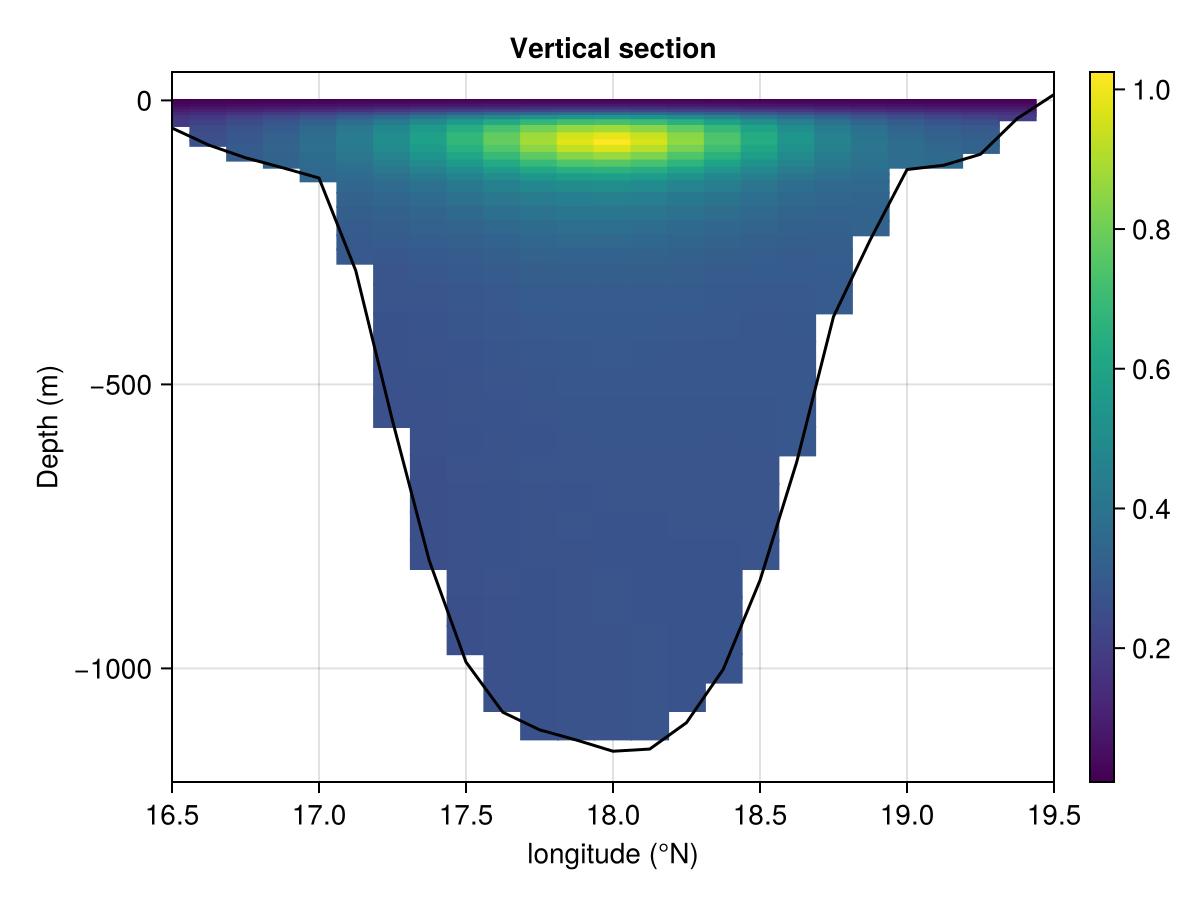

In [78]:
jcut=20

f = Figure()
ax = Axis(f[1,1], title="Vertical section", ylabel = "Depth (m)", xlabel = "longitude (°N)")
hm = heatmap!(ax, xc[:,jcut,1],-zc[1,jcut,:],fi[:,jcut,:].+obsmean)
lines!(ax, bx,-b[:,jcut], color=:black)
Colorbar(f[1, 2], hm)
xlims!(16.5,19.5)
ylims!(-1200,50)
f

#### Horizontal

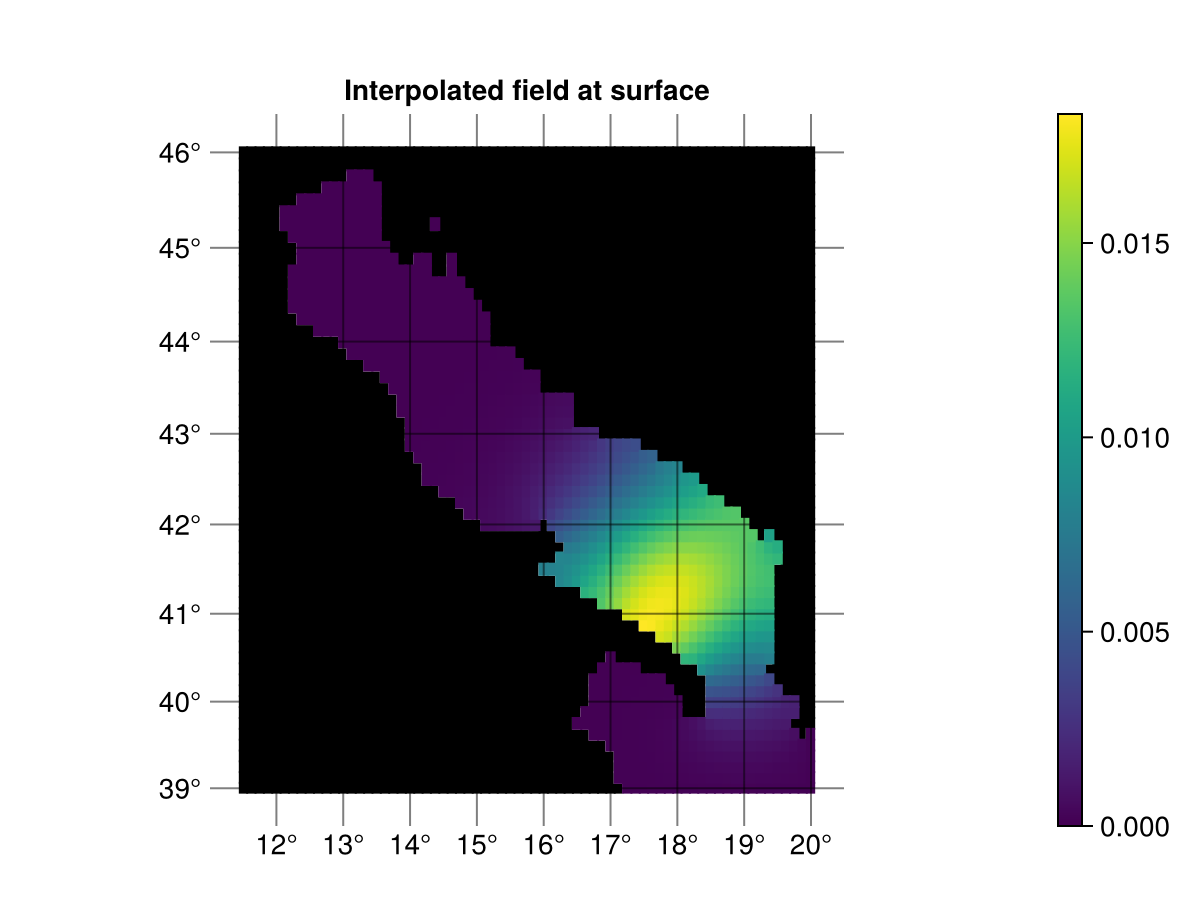

In [80]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Interpolated field at surface")
heatmap!(ax, lonr, latr, mask_edit[:,:,1], colormap=Reverse(:binary))
hm = heatmap!(ax, lonr, latr,fi[:,:,1].+obsmean)
Colorbar(f[1, 2], hm)
f

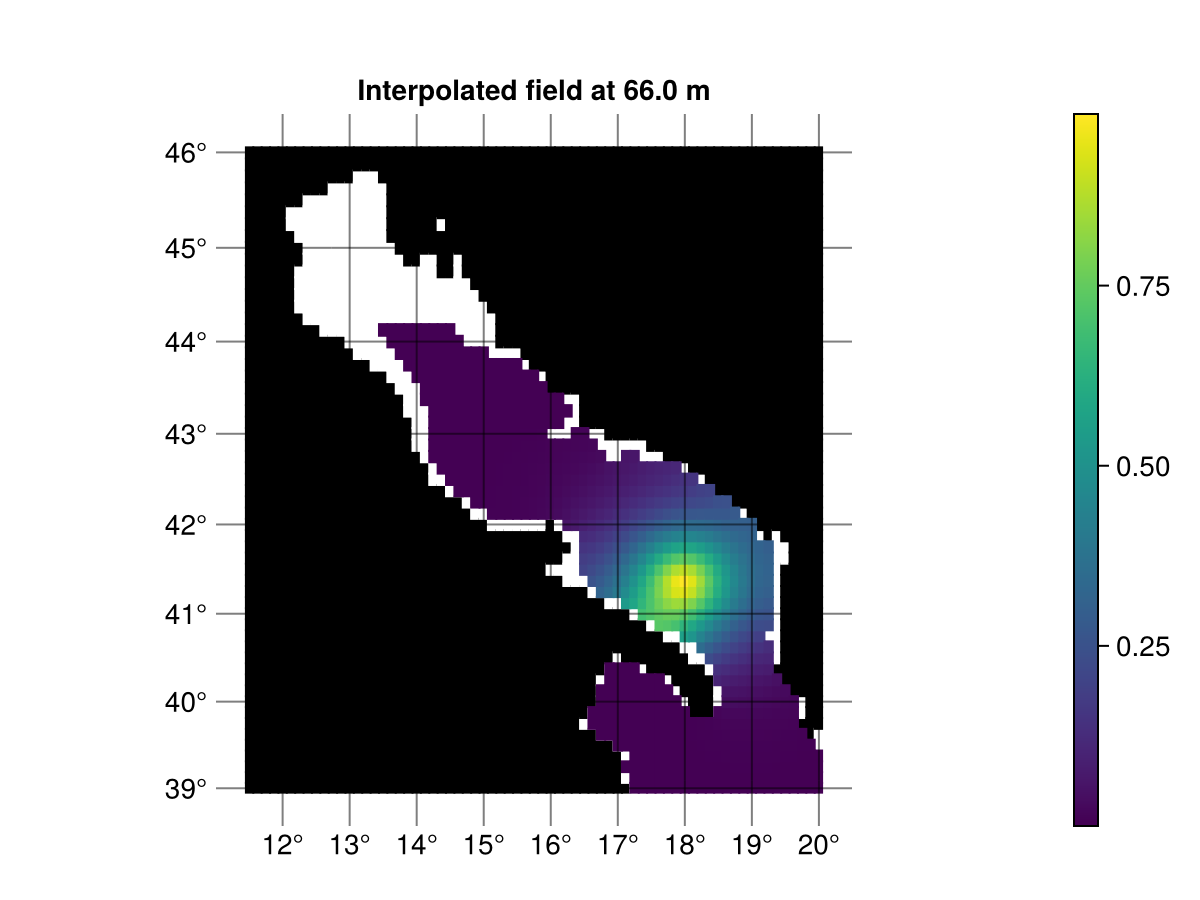

In [26]:
kcut=10

f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Interpolated field at $(depthr[kcut]) m")
heatmap!(ax, lonr, latr, mask_edit[:,:,1], colormap=Reverse(:binary))
hm = heatmap!(ax, lonr, latr,fi[:,:,kcut].+obsmean)
Colorbar(f[1, 2], hm)
f

## Coordinate change
### First define sigma coordinates (from 0 to 1)

In [27]:
Nsigma=20
xs,ys,sigma=ndgrid(lonr,latr,range(0;stop=1,length=Nsigma))
pms = ones(size(xs)) / (xs[2,1,1]-xs[1,1,1]);
pns = ones(size(xs)) / (ys[1,2,1]-ys[1,1,1]);
pos = ones(size(xs)) / (sigma[1,1,2]-sigma[1,1,1]);
sz=size(xs)
masks=trues(size(xs))
masks[:,:,:].=mask_edit[:,:,1];

In [28]:
jcut=20

20

A way to create a fake bottomgraphy just to guide the vertical grid generation.      
Take the original one with the desired mask, then filter and finally make it deep in the shallow regions (to avoid too strong changes of z lines)

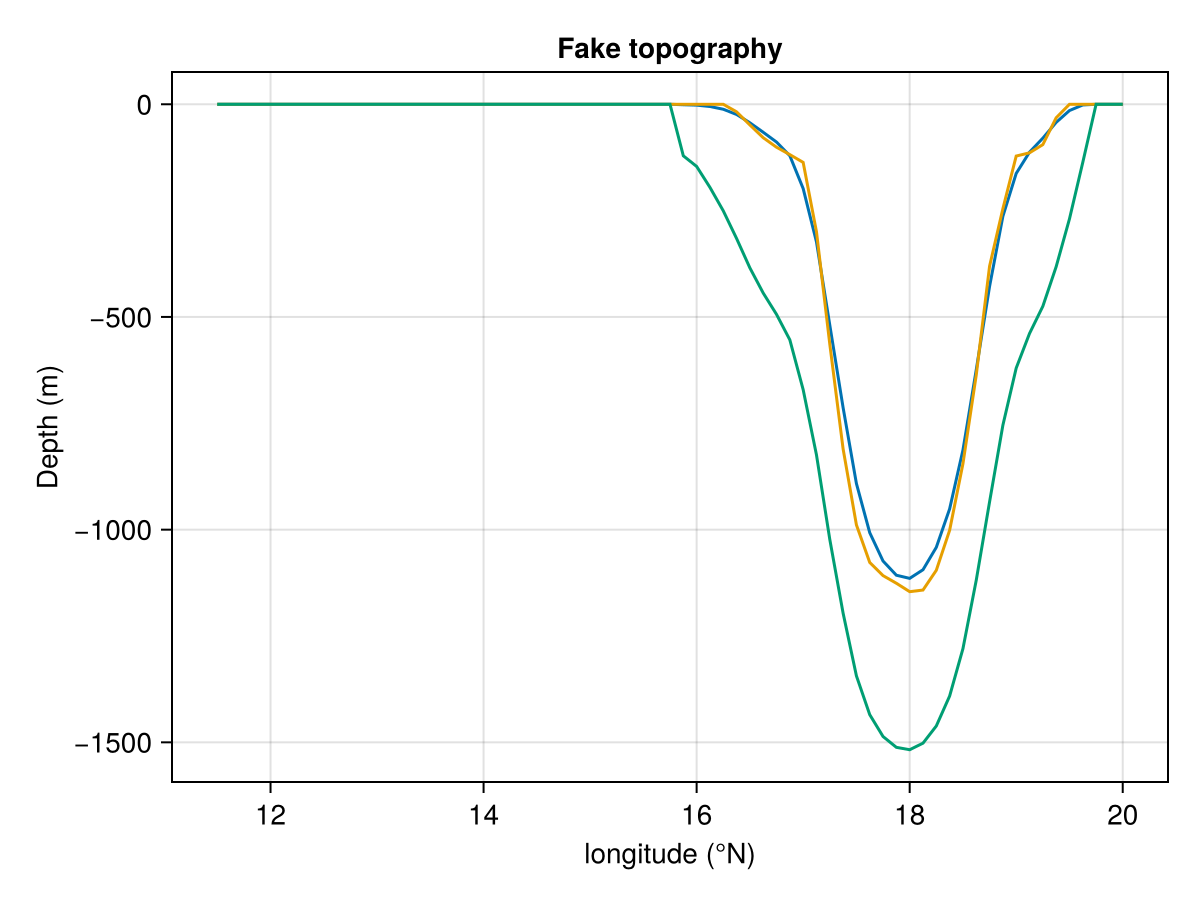

In [29]:
bfake=b.*mask_edit[:,:,1]
bfake2=DIVAnd.diffusion(trues(size(mask_edit[:,:,1])),(pms[:,:,1],pns[:,:,1]),(.09,.09),bfake)
bmax=maximum(bfake2)
bfake3=0.5.*bfake2 .+ 0.5.*(bfake2./bmax).^0.3*bmax

f = Makie.Figure()
ax = Axis(f[1,1], title="Fake topography", ylabel = "Depth (m)", xlabel = "longitude (°N)")
lines!(ax, bx,-bfake2[:,jcut])
lines!(ax, bx,-bfake[:,jcut])
lines!(ax, bx,-bfake3[:,jcut])
f

Now you can chose to create the vertical coordinate using the "exact" topography or the fake one.

In [30]:
#bfun=linear_interpolation((bx,by),b.*masks[:,:,1];extrapolation_bc=0.0)
bfun=linear_interpolation((bx,by),bfake3.*masks[:,:,1];extrapolation_bc=0.0);

Parameters for the vertical grid generation, adapted from https://getm.eu/files/GETM/doc/html/node14.html

In [31]:
du=5.001
dl=.001

DG=200
sk=sigma[1,1,2]
skm=sigma[1,1,1]
if iszero(du) && iszero(dl)
    function betaHB(sigma)
        return sigma
    end
    function invbetaHB(beta)
        return beta
    end
else
    function betaHB(sigma)
        #if du and dl are zero just return sigma
        return -(tanh((dl+du)*(1.0 - sigma) - dl)+tanh(dl))/(tanh(du)+tanh(dl))+1.0
    end
    function invbetaHB(beta)
    # test needed, not for the gridding but for data that might fall outside of the grid
        if beta>1.0 || beta<-1.0
            return beta
        end
    #if du and dl are zero just return beta
        return 1.0-(atanh(-(beta-1.0)*(tanh(du)+tanh(dl))-tanh(dl))+dl)/(dl+du)
    
    end
end
    
function alphaHB(x,y)
   
    alphanum=(betaHB(sk)-betaHB(skm))+DG/max(2.0,bfun(x,y))*(sk-skm)
    alphaden=(betaHB(sk)-betaHB(skm))+(sk-skm)
    alpha=max(min(alphanum/alphaden,1.0),0.0)
    return alpha
end
    
function sigmatoz(x,y,sigma)
    alpha=alphaHB(x,y)
    return ((1-alpha)*betaHB(sigma)+alpha*sigma)*max(2.0,bfun(x,y))
end
# For more general cases the inverse will need some
# search of zeros. Needed to get fracional indexes and horizontal plots

function ztosigma(x,y,z)
    gamma=z/max(2.0,bfun(x,y))
    alpha=alphaHB(x,y)
    if alpha<0.001 
        return invbetaHB(gamma)
    end
    if alpha>0.999
        return gamma
    end
    guess=alpha*gamma+(1-alpha)*invbetaHB(gamma)
    # now improve by finding zero
    guess=find_zero(x->alpha*x+(1-alpha)*betaHB(x)-gamma, guess)
    return guess
end

ztosigma (generic function with 1 method)

In [32]:
# Check inverse function
var(invbetaHB.(betaHB.(sigma))-sigma),var(sigma)

(8.093915240063089e-28, 0.09210643410162853)

In [33]:
zs=sigmatoz.(xs,ys,sigma)
# Check inverse function
testsigma=ztosigma.(xs,ys,zs)
var(testsigma.-sigma),var(sigma)

(2.2251582626500827e-34, 0.09210643410162853)

We already have the `z` positions of the sigma layers `zs`.        
So now just recalculate the metrics:

In [34]:
pozc=deepcopy(pos)
for i = 1:sz[3]
    i0 = max(i - 1, 1)
    i1 = min(i + 1, sz[3])
    pozc[:,:,i].=(i1-i0)./(zs[:,:,i1].-zs[:,:,i0])
end

Now make the mask by using the zs positions of the grid and use the "real" topography for the mask:

In [35]:
bm=b.*mask_edit[:,:,1]
for k=1:size(zs)[3]
    masks[:,:,k].=zs[:,:,k].<bm[:,:] .&& mask_edit[:,:,1]
end

### Plots

In [90]:
extrema(-zs[:,jcut,:])

(-1517.4194181408898, -0.0)

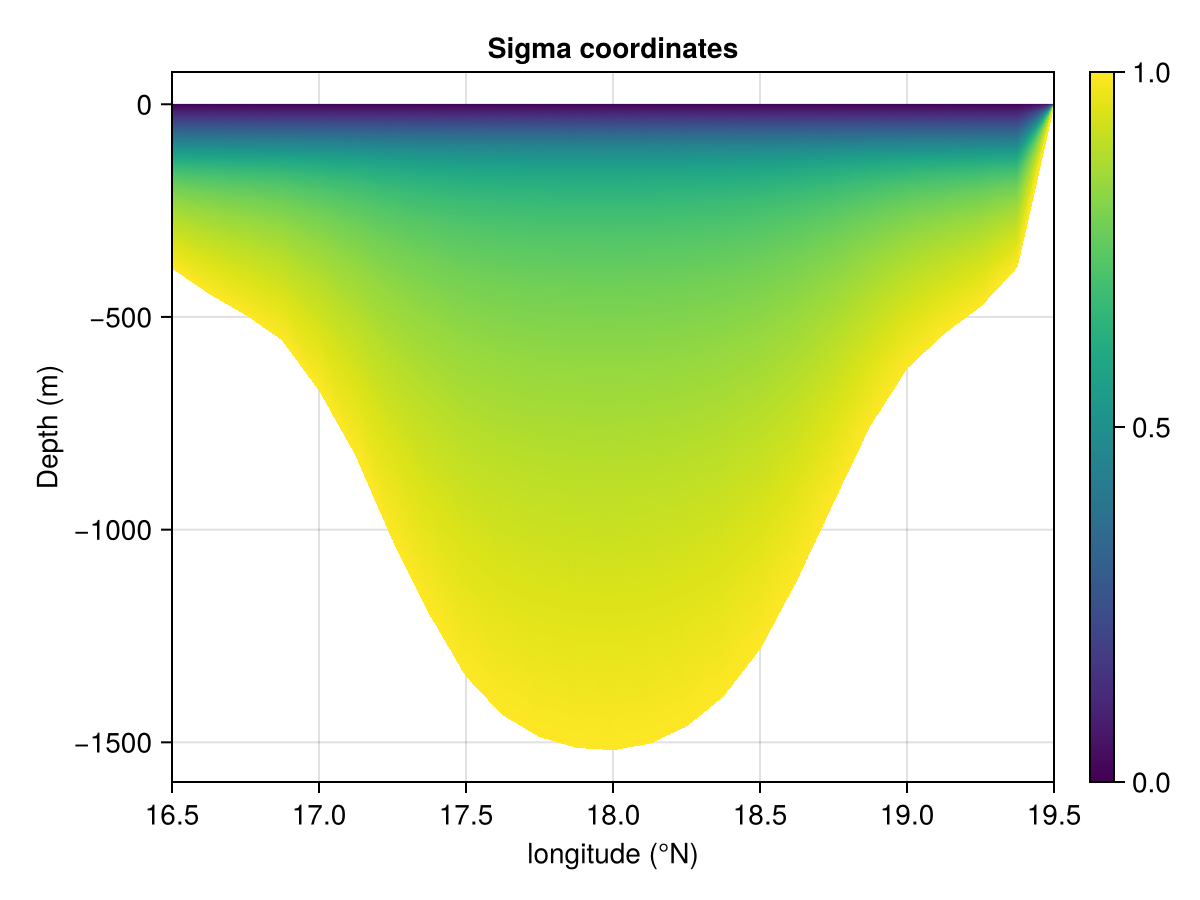

In [86]:
f = Figure()
ax = Axis(f[1,1], title="Sigma coordinates", ylabel = "Depth (m)", xlabel = "longitude (°N)")
hm = surface!(ax, xs[:,jcut,:],-zs[:,jcut,:],sigma[:,jcut,:], shading=NoShading, interpolate=false)
xlims!(16.5,19.5)
Colorbar(f[1, 2], hm)
f

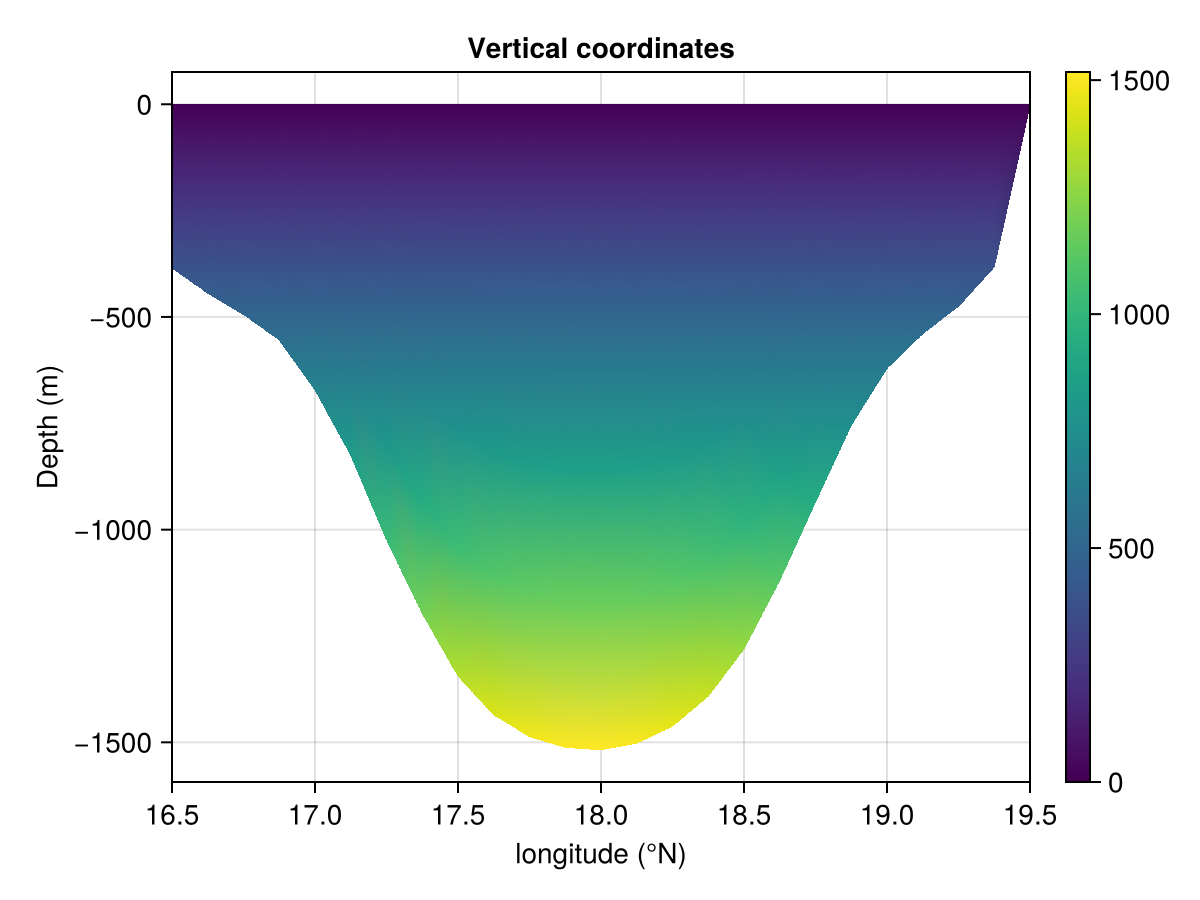

In [41]:
f = Figure()
ax = Axis(f[1,1], title="Vertical coordinates", ylabel = "Depth (m)", xlabel = "longitude (°N)")
hm = surface!(ax, xs[:,jcut,:],-zs[:,jcut,:],zs[:,jcut,:], shading=NoShading)
xlims!(16.5,19.5)
Colorbar(f[1, 2], hm)
f

### Vertical position in sigma space

In [42]:
obssigma=ztosigma.(obslon,obslat,obsdepth)

1-element Vector{Float64}:
 0.372883425463071

### Get fractional indexes by working in sigma space:

In [43]:
Igrid = localize_separable_grid((obslon,obslat,obssigma), masks, (xs,ys,sigma), iscyclic)

lenx = fill(LHOR,sz)  
leny = lenx./aspectratio
lenz = Lvert.(xs,ys,zs);
epsilon2 = eps2;

fi,s=DIVAndrun(masks,(pms,pns,pozc),(xs,ys,zs),(obslon,obslat,obsdepth),obsval.-obsmean,
    (lenx,leny,lenz),epsilon2;fracindex =Igrid);

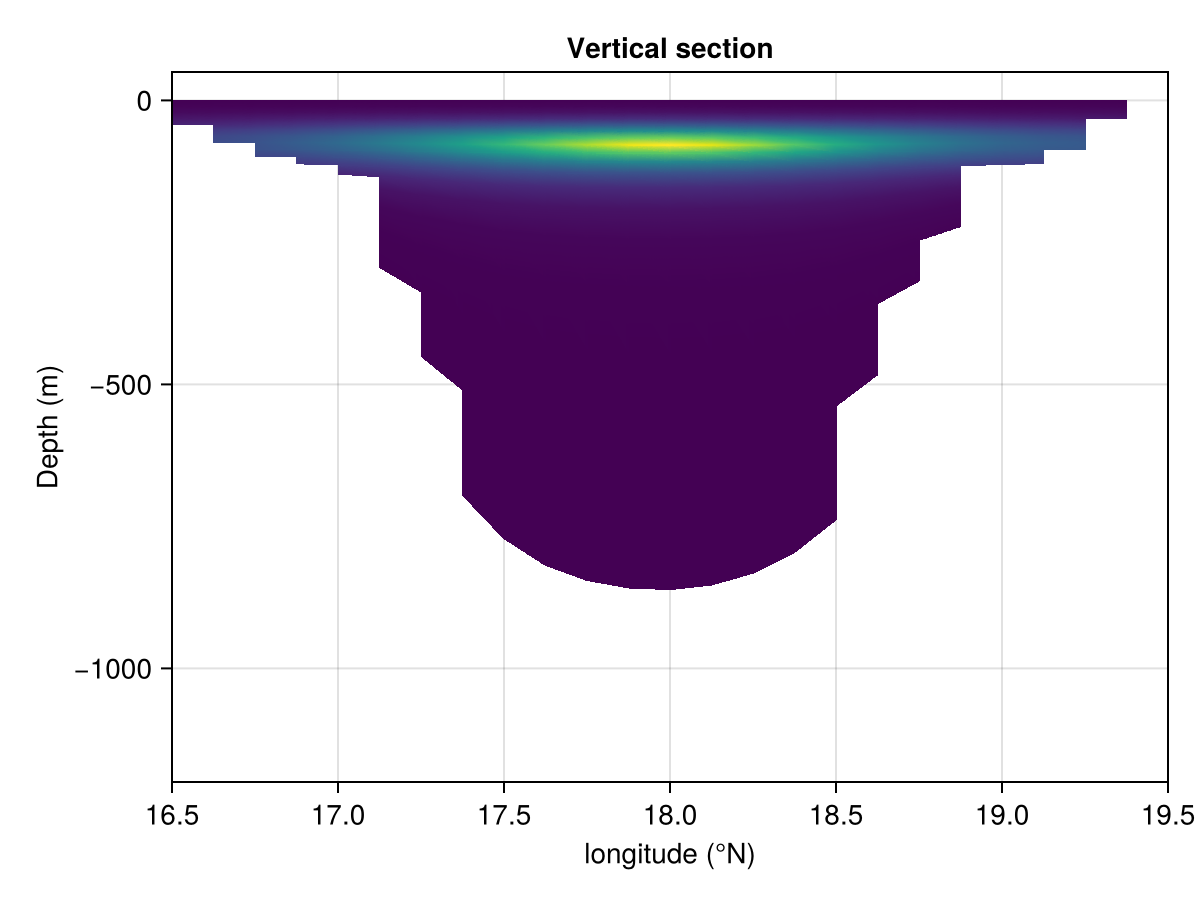

In [44]:
f = Figure()
ax = Axis(f[1,1], title="Vertical section", ylabel = "Depth (m)", xlabel = "longitude (°N)")
hm = surface!(ax, xs[:,jcut,:],-zs[:,jcut,:],fi[:,jcut,:].+obsmean, interpolate=false, 
    colorrange=[0,1], shading=NoShading)
xlims!(16.5,19.5)
ylims!(-1200,50)
f

## How to make a horizontal plot



In [45]:
# Define depth for cut
zcut=zc[1,1,kcut]
# Create fake data and calculte sigma values on the constant z surface
sigmaonzlevel=ztosigma.(xs[:,:,1],ys[:,:,1],zcut.+ 0.0 .*ys[:,:,1])

# Get fractional indexes of the fake data and the observing operator
Igridcut=localize_separable_grid((xs[:,:,1],ys[:,:,1],sigmaonzlevel), masks, (xs,ys,sigma), )
Htoz, out, outbbox = sparse_interp(masks, Igridcut, iscyclic)
Htoz=Htoz*transpose(sparse_pack(masks))

# Now observe the gridded field with that observation operator
zlevelsol=Htoz*statevector_pack(s.sv, (fi,))

# Put it in shape for plotting
soltoplot=reshape(zlevelsol,size(xs)[1:2])
# Need to apply mask because that is not included in the interpolation
soltoplot[zcut.>b].=NaN
soltoplot[mask_edit[:,:,1].==0].=NaN;

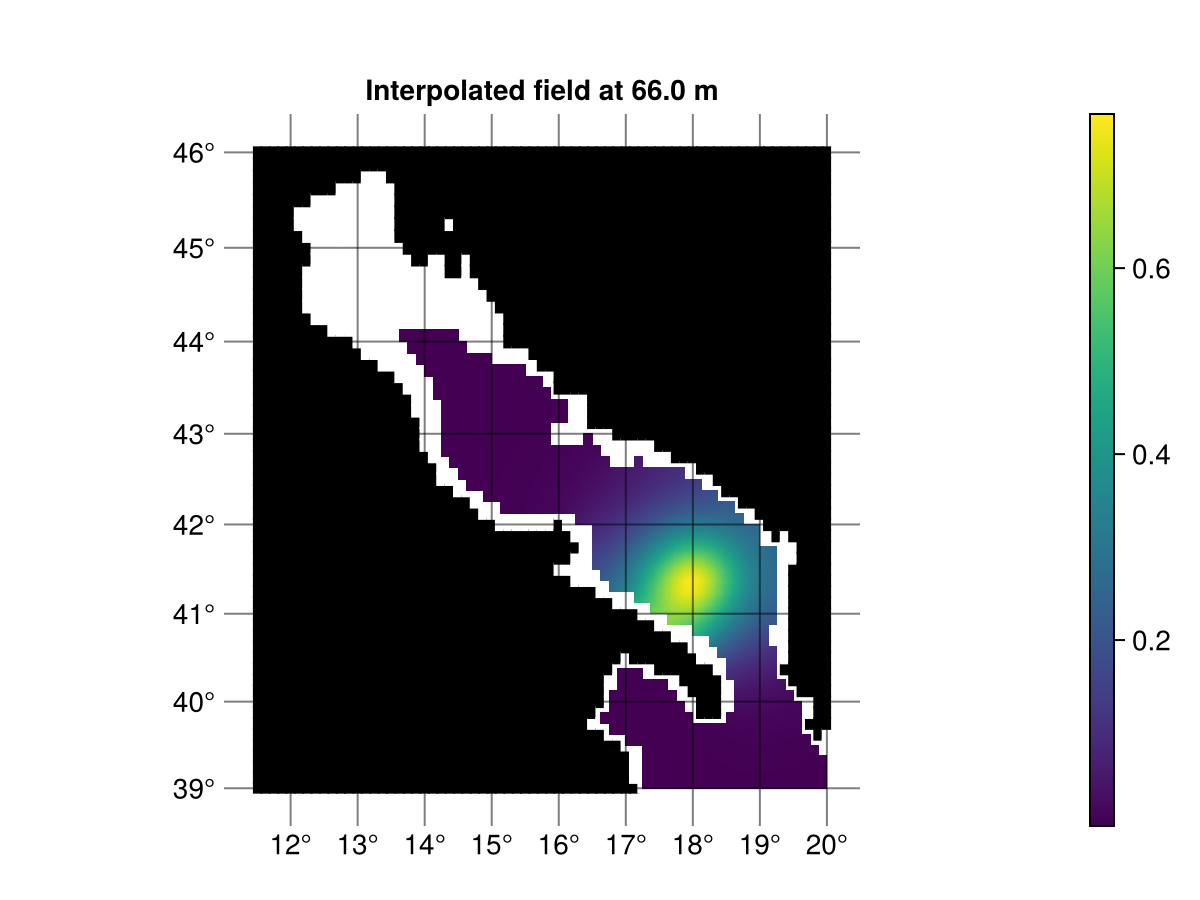

In [46]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Interpolated field")
heatmap!(ax, lonr, latr, mask_edit[:,:,1], colormap=Reverse(:binary))
su = surface!(ax, xs[:,:,1],ys[:,:,1],soltoplot.+obsmean, shading=NoShading)
Colorbar(f[1, 2], su)
f

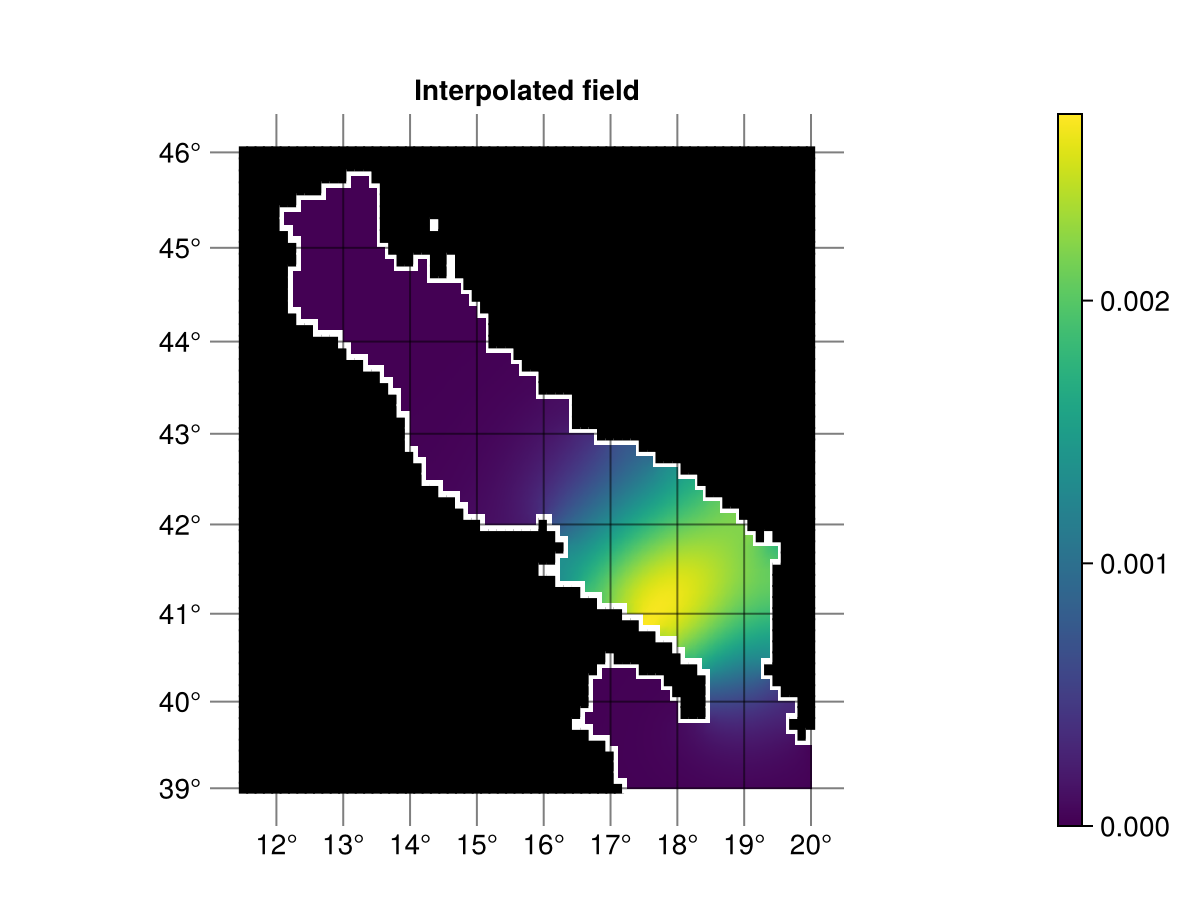

In [48]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Interpolated field")
heatmap!(ax, lonr, latr, mask_edit[:,:,1], colormap=Reverse(:binary))
su = surface!(ax, xs[:,:,1],ys[:,:,1],fi[:,:,1].+obsmean, shading=NoShading)
Colorbar(f[1, 2], su)
f